In [1]:
!pip install qiskit==1.3.0 qiskit-aer==0.15.1 qiskit-machine-learning==0.8.1
!pip install torchvision==0.20.1 scikit-learn==1.6.0rc1 matplotlib==3.9.3
!pip install loguru
!pip install opencv-python
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 32.2 MB/s eta 0:00:00
   ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/906.4 MB 142.1 MB/s eta 0:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 8

In [ ]:
from sklearn.decomposition import PCA
from loguru import logger

import tensorflow as tf

import cv2
import pandas as pd
import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torchvision import datasets, transforms
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import ParameterVector, Parameter

from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler

import random

seed_value = 12345
algorithm_globals.random_seed = seed_value
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

n_qubits = 8
n_features = 8
n_samples = 100

output_shape = 2

maxiter = 150

options = {'seed': 12345, 'shots': 4096}

In [3]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective Function Value vs. Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Downloading the dataset and preprocessing the data

In [ ]:
def data_load_and_process_mnist(
        num_classes,
        all_samples,
        seed,
        num_examples_per_class,
        n_features=8,
):
    if seed is not None:
        tf.random.set_seed(seed)
        np.random.seed(seed)

    transform = transforms.ToTensor()
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    x_train = mnist_train.data.numpy().astype(np.float32) / 255.0
    y_train = mnist_train.targets.numpy()

    x_test = mnist_test.data.numpy().astype(np.float32) / 255.0
    y_test = mnist_test.targets.numpy()

    x_train = np.expand_dims(x_train, 1)
    x_test = np.expand_dims(x_test, 1)

    if not all_samples:
        selected_indices = []

        for class_label in range(10):
            indices = np.where(y_train == class_label)[0][:num_examples_per_class]
            selected_indices.extend(indices)

        x_train_subset = x_train[selected_indices]
        y_train_subset = y_train[selected_indices]

        shuffle_indices = np.random.permutation(len(x_train_subset))
        x_train = x_train_subset[shuffle_indices]
        y_train = y_train_subset[shuffle_indices]

    logger.info("Shape of subset training data: {}", x_train.shape)
    logger.info("Shape of subset training labels: {}", y_train.shape)

    mask_train = np.isin(y_train, range(0, num_classes))
    mask_test = np.isin(y_test, range(0, num_classes))


    X_train = x_train[mask_train].reshape(-1, 784)
    X_test = x_test[mask_test].reshape(-1, 784)

    Y_train = y_train[mask_train]
    Y_test = y_test[mask_test]

    logger.info("Shape of subset training data: {}", X_train.shape)
    logger.info("Shape of subset training labels: {}", Y_train.shape)
    logger.info("Shape of testing data: {}", X_test.shape)
    logger.info("Shape of testing labels: {}", Y_test.shape)

    pca = PCA(n_features)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)


    X_train = (X_train - X_train.min()) * (np.pi / (X_train.max() - X_train.min()))
    X_test = (X_test - X_test.min()) * (np.pi / (X_test.max() - X_test.min()))

    return X_train, X_test, Y_train, Y_test

In [5]:
X_train, X_test, Y_train, Y_test = data_load_and_process_mnist(
    num_classes=output_shape,
    all_samples=False,
    seed=seed_value,
    num_examples_per_class=n_samples,
    n_features=n_features,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]
2025-12-19 10:13:27.560 | INFO     | __main__:data_load_and_process_mnist:39 - Shape of subset training data: (1000, 1, 28, 28)
2025-12-19 10:13:27.561 | INFO     | __main__:data_load_and_process_mnist:40 - Shape of subset training labels: (1000,)
2025-12-19 10:13:27.569 | INFO     | __main__:data_load_and_process_mnist:52 - Shape of subset training data: (200, 784)
2025-12-19 10:13:27.570 | INFO     | __main__:data_load_and_process_mnist:53 - Shape of subset training labels: (200,)
2025-12-19 10:13:27.571 | INFO     | __main__:data_load_and_process_mnist:54 - Shape of testing data: (2115, 784)
2025-12-19 10:13:27.573 | INFO     | __main__:data_load_and_process_mnist:55 - Shape of testing labels: (2115,)


### Real Amplitudes ansatz

Image classification with a RealAmplitudes ansatz

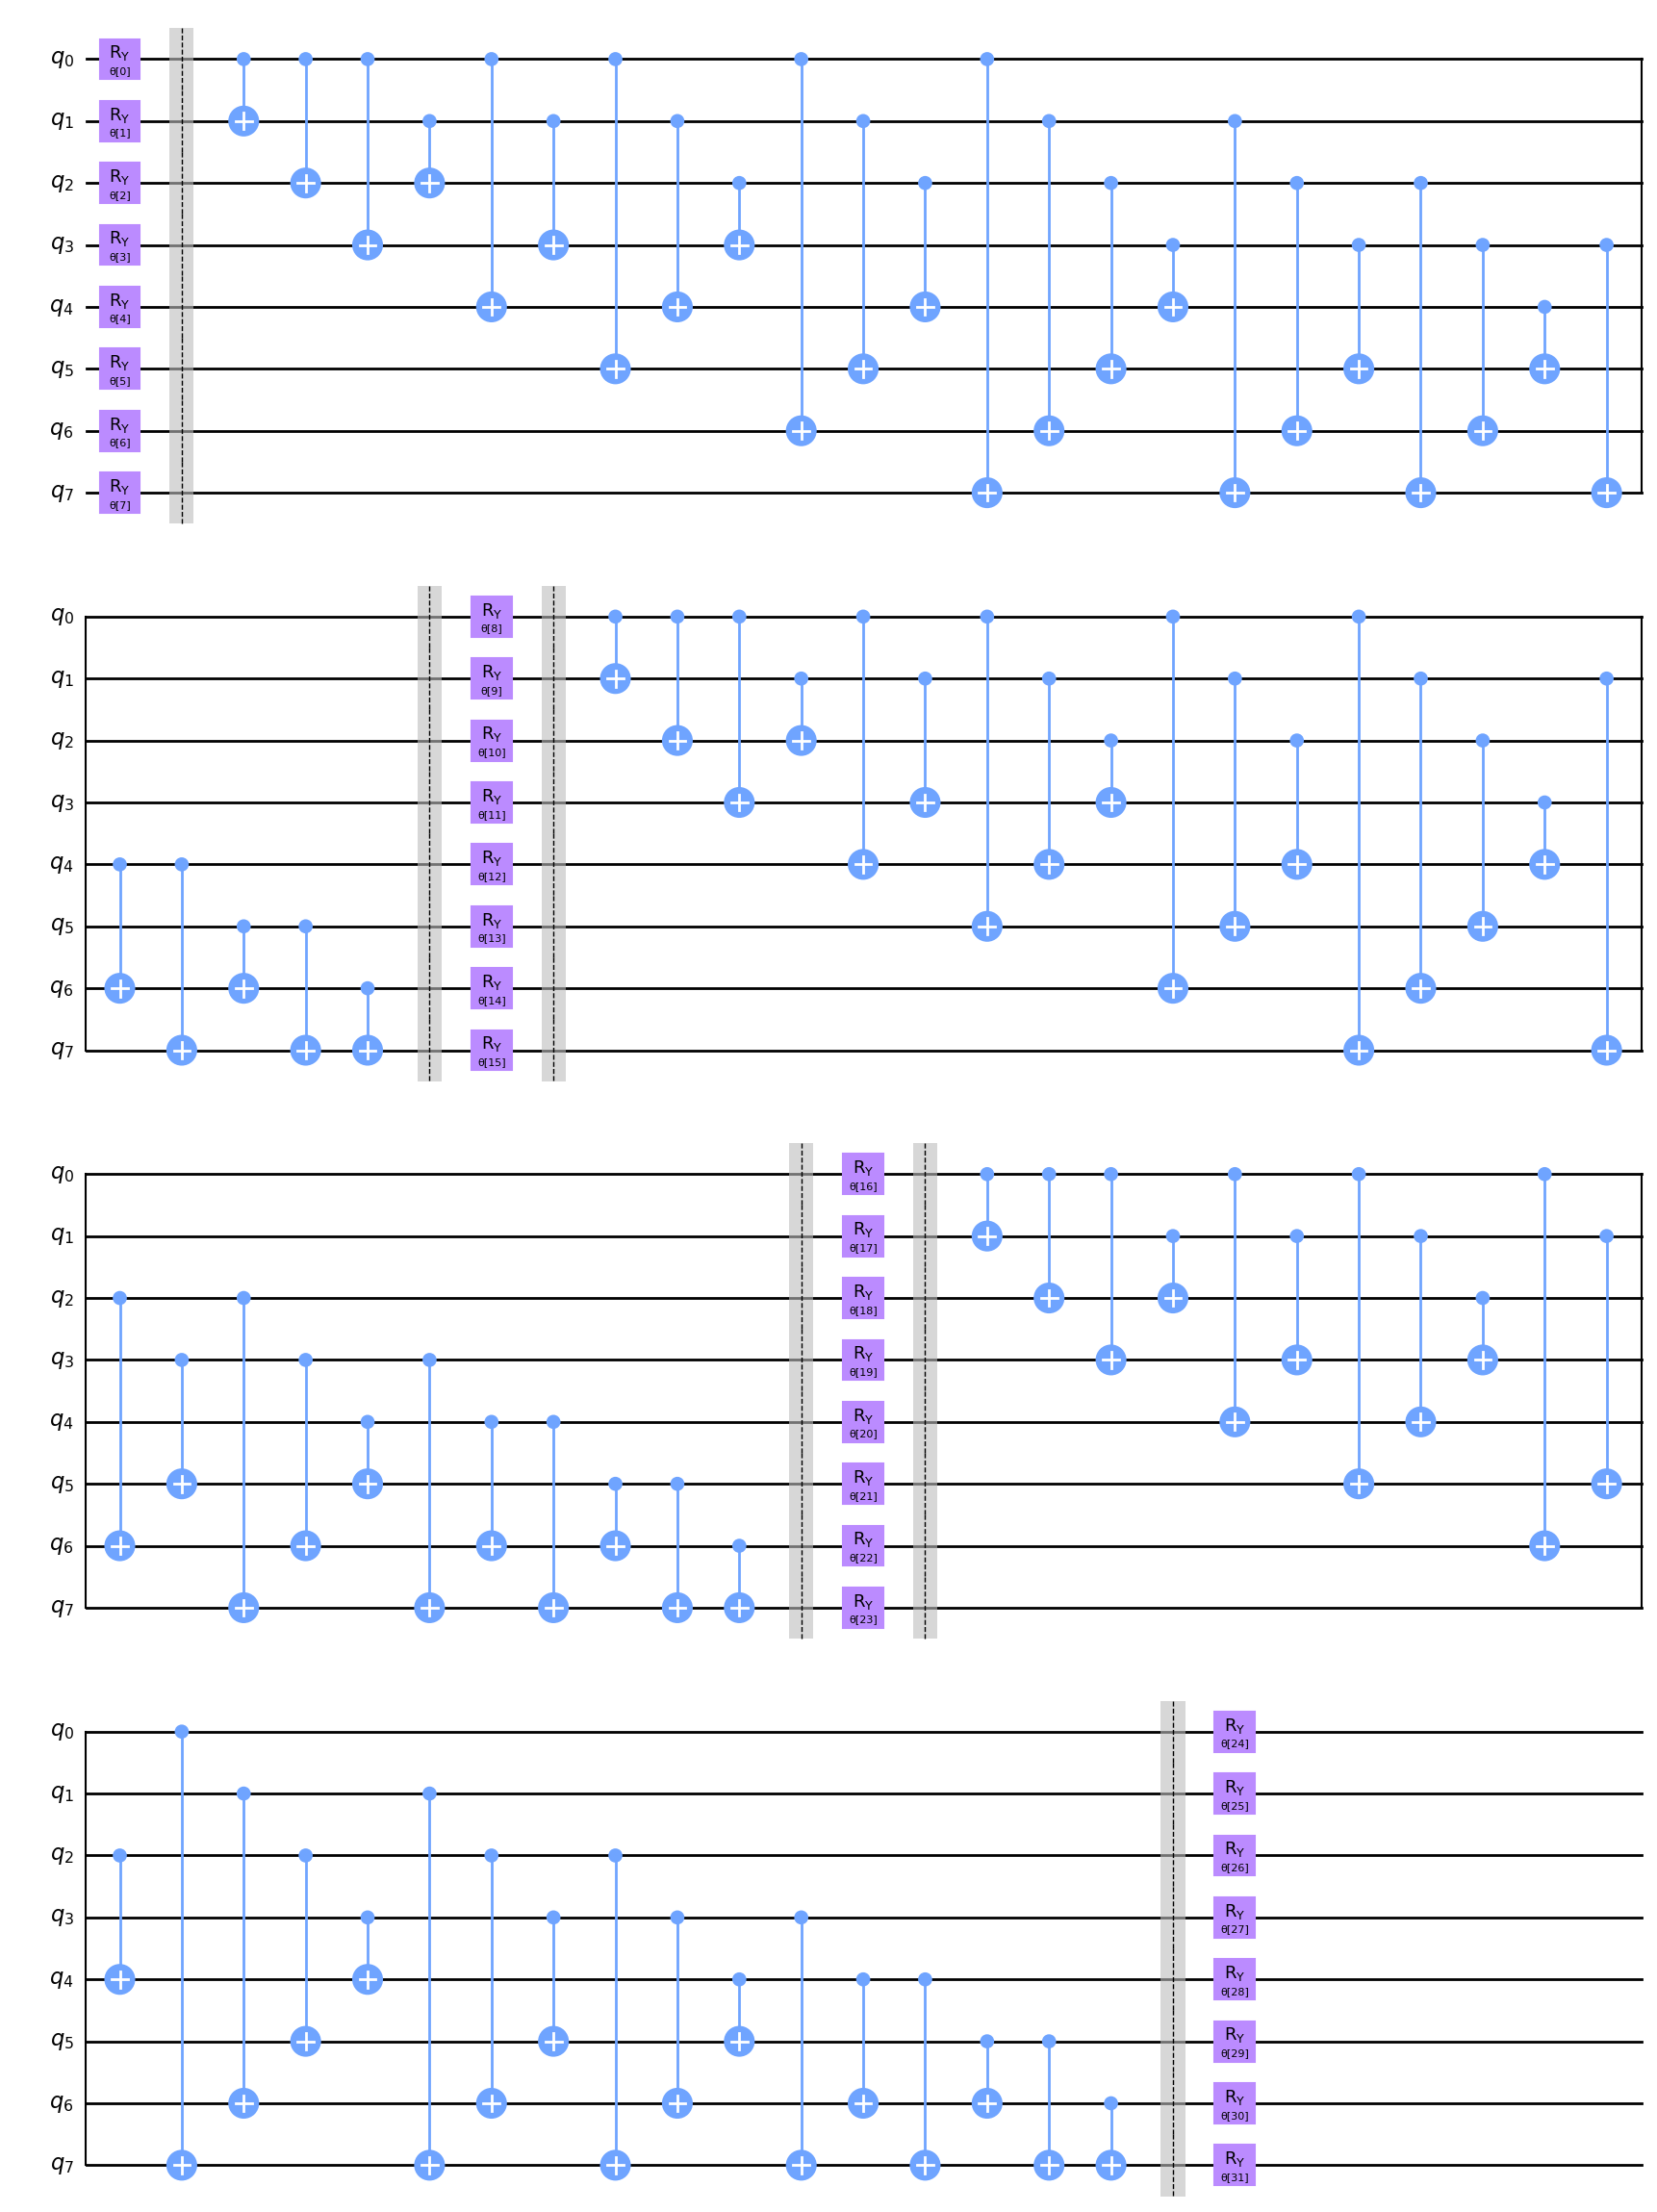

In [6]:
ansatz = RealAmplitudes(
    num_qubits=n_qubits,
    reps=3,
    entanglement='full',
    insert_barriers=True,
    )
ansatz.decompose().draw('mpl', style="clifford")

In [7]:
ansatz.num_parameters

32

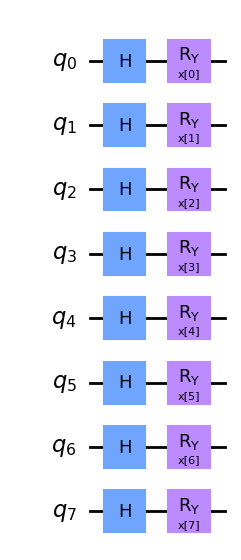

In [9]:
feature_map = QuantumCircuit(n_qubits)
feature_params = ParameterVector('x', n_qubits)
i=0
for i in range(n_qubits):
    feature_map.h(i)
    feature_map.ry(feature_params[i], i)


feature_map.draw('mpl', style="clifford")

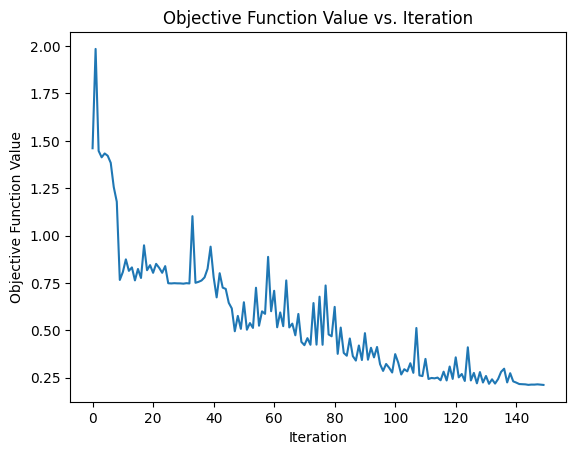

In [10]:
sampler = Sampler(options=options)
objective_func_vals = []

initial_point = [0.5] * ansatz.num_parameters

classifier = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=maxiter),
    callback=callback_graph,
    loss='cross_entropy',
    output_shape=output_shape,
    initial_point=initial_point,
)

classifier.fit(X_train, Y_train)

In [11]:
classifier.score(X_test, Y_test)

0.992434988179669

### QCNN

Basic version of QCNN implementation.

https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

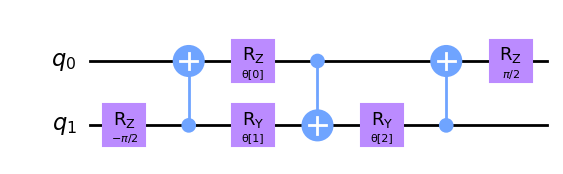

In [ ]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")


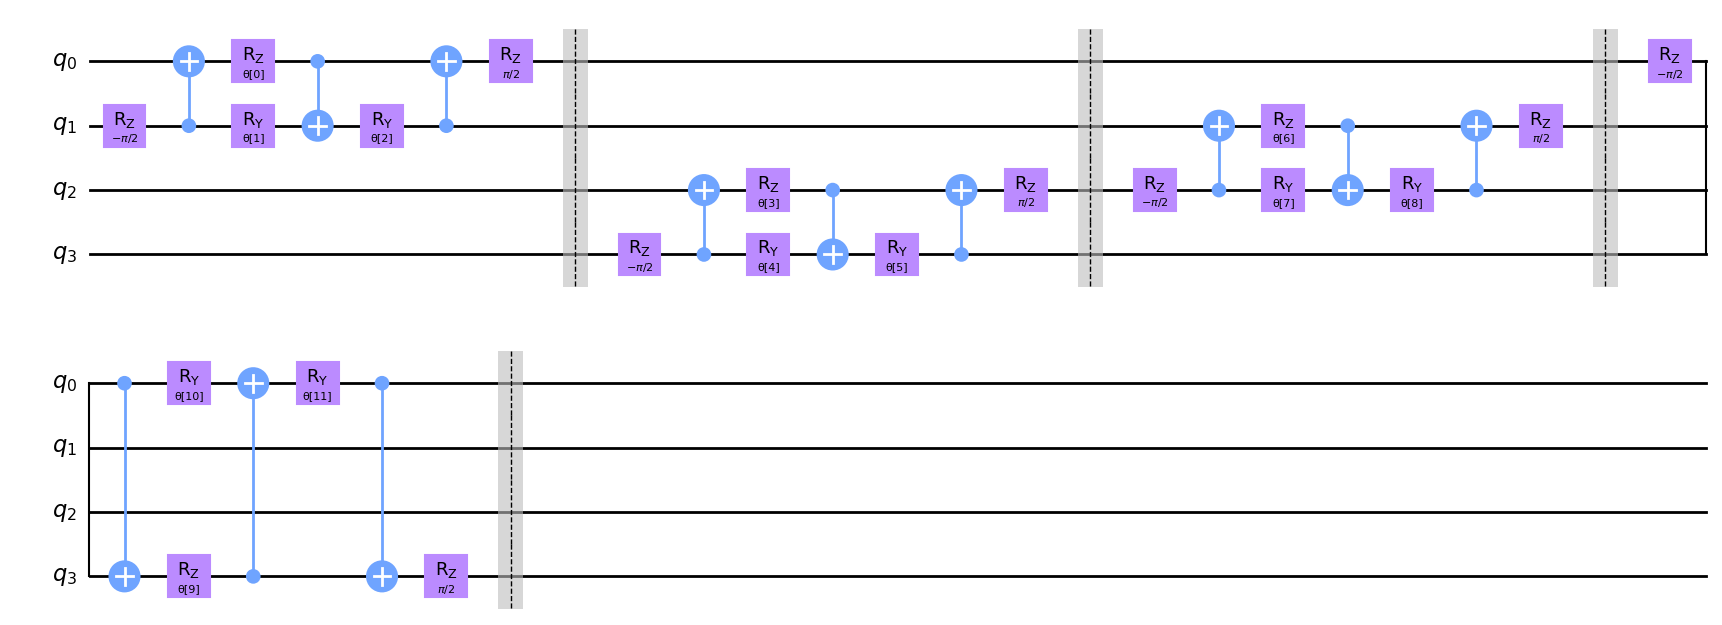

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index: (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index: (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

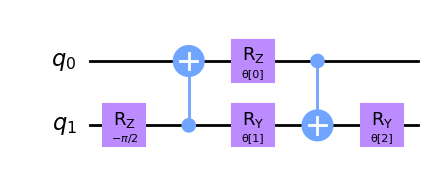

In [ ]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

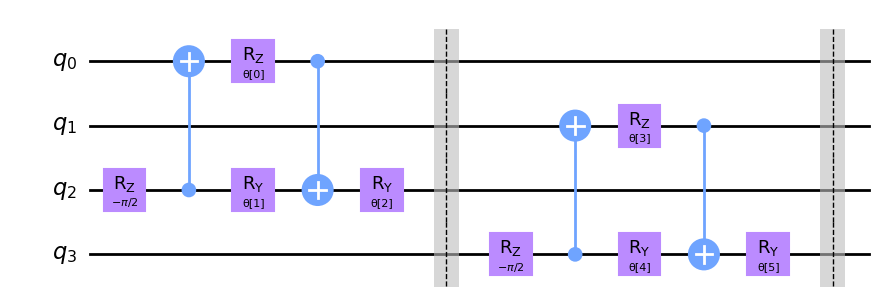

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index: (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [ ]:
def create_qcnn(num_qubits):
    assert num_qubits % 2 == 0, 'num_qubits must be odd'

    ansatz = QuantumCircuit(num_qubits)

    start_qubits = 0
    idx = 1

    while (num_qubits - start_qubits) > 1:
        # Convolutional layers
        ansatz.compose(
            conv_layer(num_qubits - start_qubits, f"c{idx}"),
            list(range(start_qubits, num_qubits)),
            inplace=True)

        # Pooling layers
        ansatz.compose(
            pool_layer(
                sources=list(range(0, ((num_qubits - start_qubits) // 2))),
                sinks=list(range(((num_qubits - start_qubits) // 2), num_qubits - start_qubits)),
                param_prefix=f"p{idx}"),
            list(range(start_qubits, num_qubits)), inplace=True)

        start_qubits = start_qubits + (num_qubits - start_qubits) // 2
        idx += 1

    return ansatz

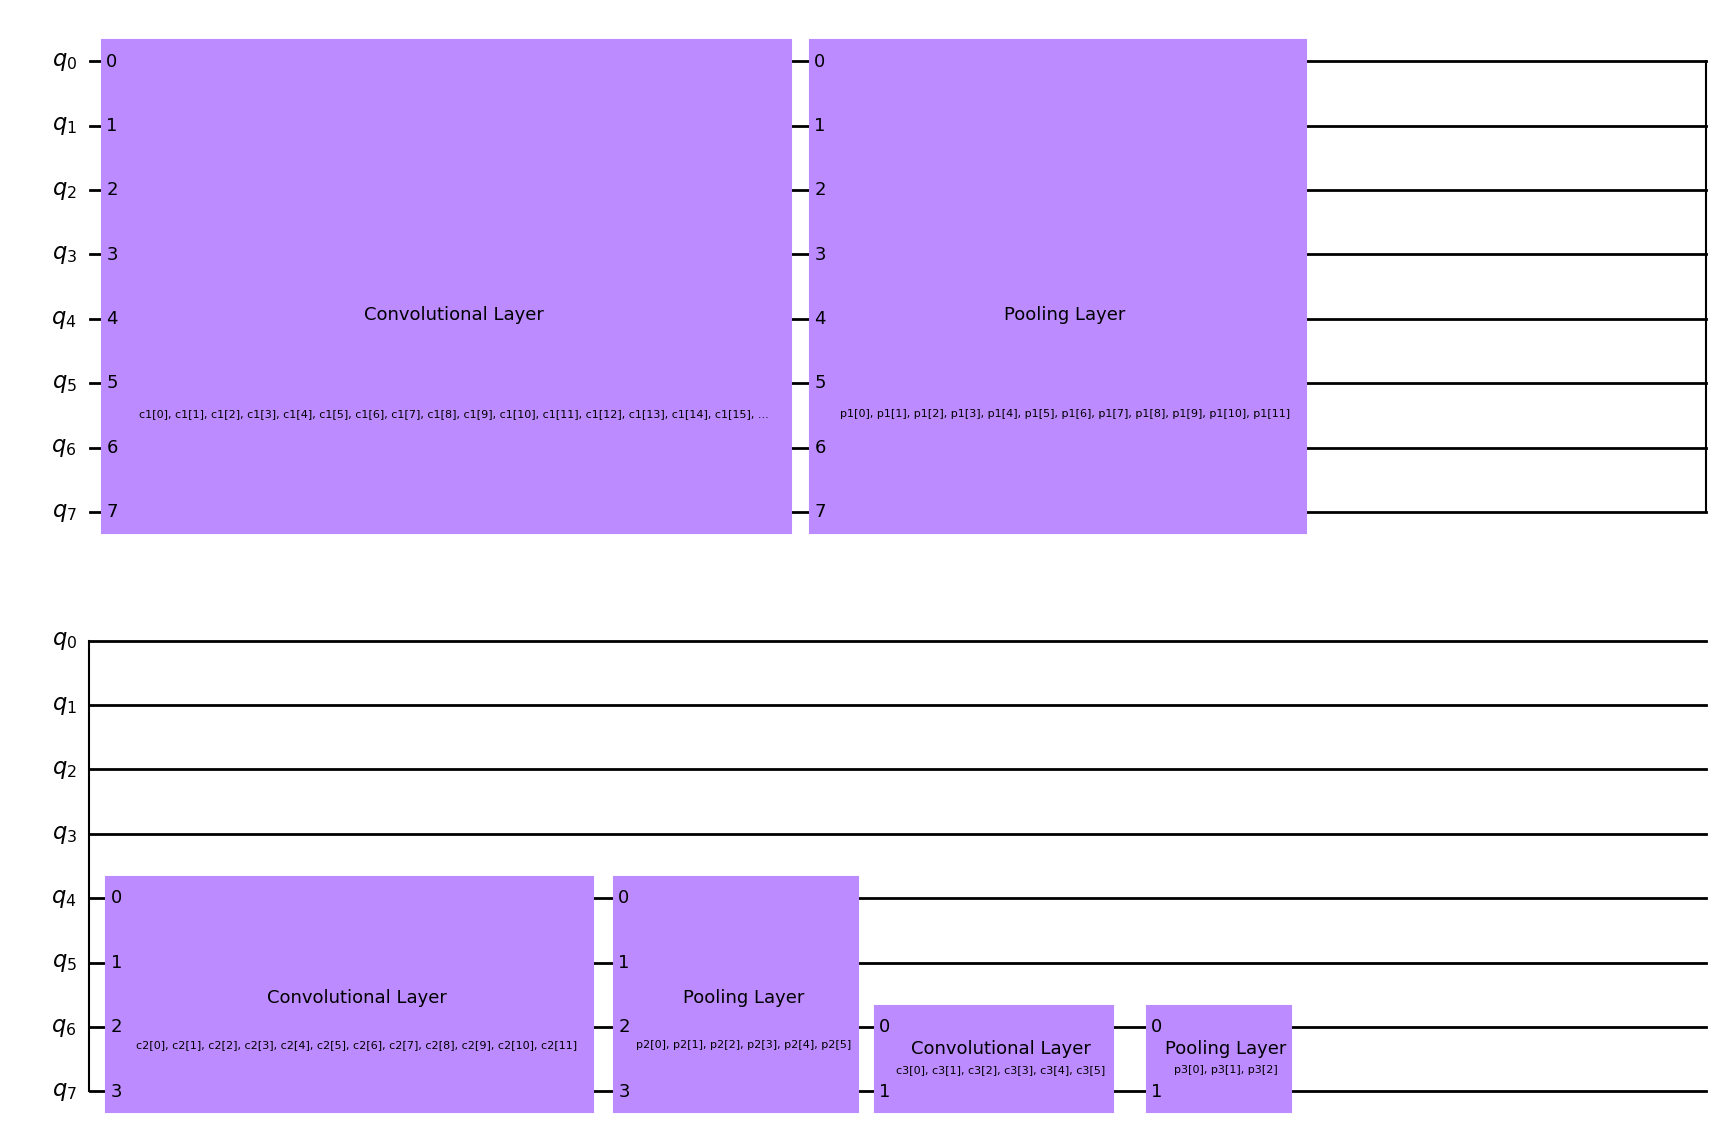

In [ ]:
ansatz = create_qcnn(n_qubits)
ansatz.draw('mpl', style="clifford")

In [ ]:
ansatz.num_parameters

63

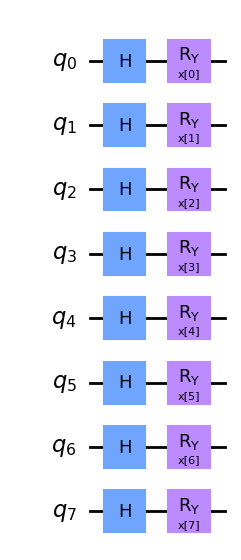

In [ ]:
feature_map = QuantumCircuit(n_qubits)
feature_params = ParameterVector('x', n_qubits)
i=0
for i in range(n_qubits):
    feature_map.h(i)
    feature_map.ry(feature_params[i], i)


feature_map.draw('mpl', style="clifford")

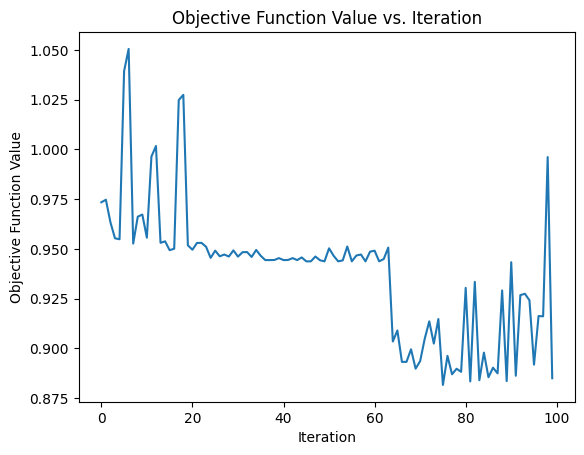

In [ ]:
sampler = Sampler(options=options)

objective_func_vals = []
initial_point = [0.5] * ansatz.num_parameters

classifier = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=maxiter),
    callback=callback_graph,
    loss='cross_entropy',
    output_shape=output_shape,
    initial_point=initial_point,
)

classifier.fit(X_train, Y_train)

In [ ]:
classifier.score(X_test, Y_test)

0.6472813238770686

QCNN proposed in: Multi-Class Quantum Convolutional Neural Networks by Amoretti et al.

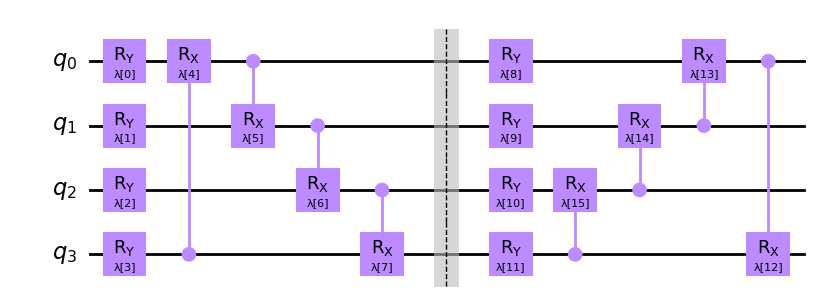

In [12]:
def F1(params, num_qubits):
    qc = QuantumCircuit(num_qubits)
    n = num_qubits

    for i in range(n):
        qc.ry(params[i], i)

    for i in range(n):
        qc.crx(params[i + n], (i - 1) % n, i)
    qc.barrier()

    for i in range(n):
        qc.ry(params[i + 2*n], i)

    if (n % 3 == 0) or (n == 2):
        for i in reversed(range(n)):
            qc.crx(params[i + 3*n], i, (i - 1) % n)
    else:
        control = n - 1
        target = (control + 3) % n
        for i in reversed(range(n)):
            qc.crx(params[i + 3*n], control, target)
            control = target
            target = (control + 3) % n
    return qc


params = ParameterVector('λ', length=16)
qc = F1(params, 4)
qc.draw('mpl', style="clifford")


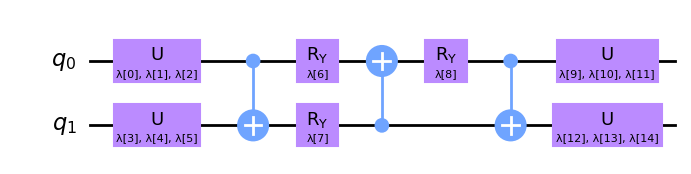

In [13]:
def F2(params):
    qc = QuantumCircuit(2)
    qc.u(params[0], params[1], params[2], 0)
    qc.u(params[3], params[4], params[5], 1)
    qc.cx(0, 1)
    qc.ry(params[6], 0)
    qc.ry(params[7], 1)
    qc.cx(1, 0)
    qc.ry(params[8], 0)
    qc.cx(0, 1)
    qc.u(params[9], params[10], params[11], 0)
    qc.u(params[12], params[13], params[14], 1)
    return qc
params = ParameterVector('λ', length=15)
qc = F2(params)
qc.draw('mpl', style="clifford")

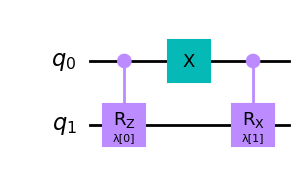

In [14]:
def P(params):
    qc = QuantumCircuit(2)
    qc.crz(params[0], 0, 1)
    qc.x(0)
    qc.crx(params[1], 0, 1)
    return qc

params = ParameterVector('λ', length=2)
qc = P(params)
qc.draw('mpl', style="clifford")

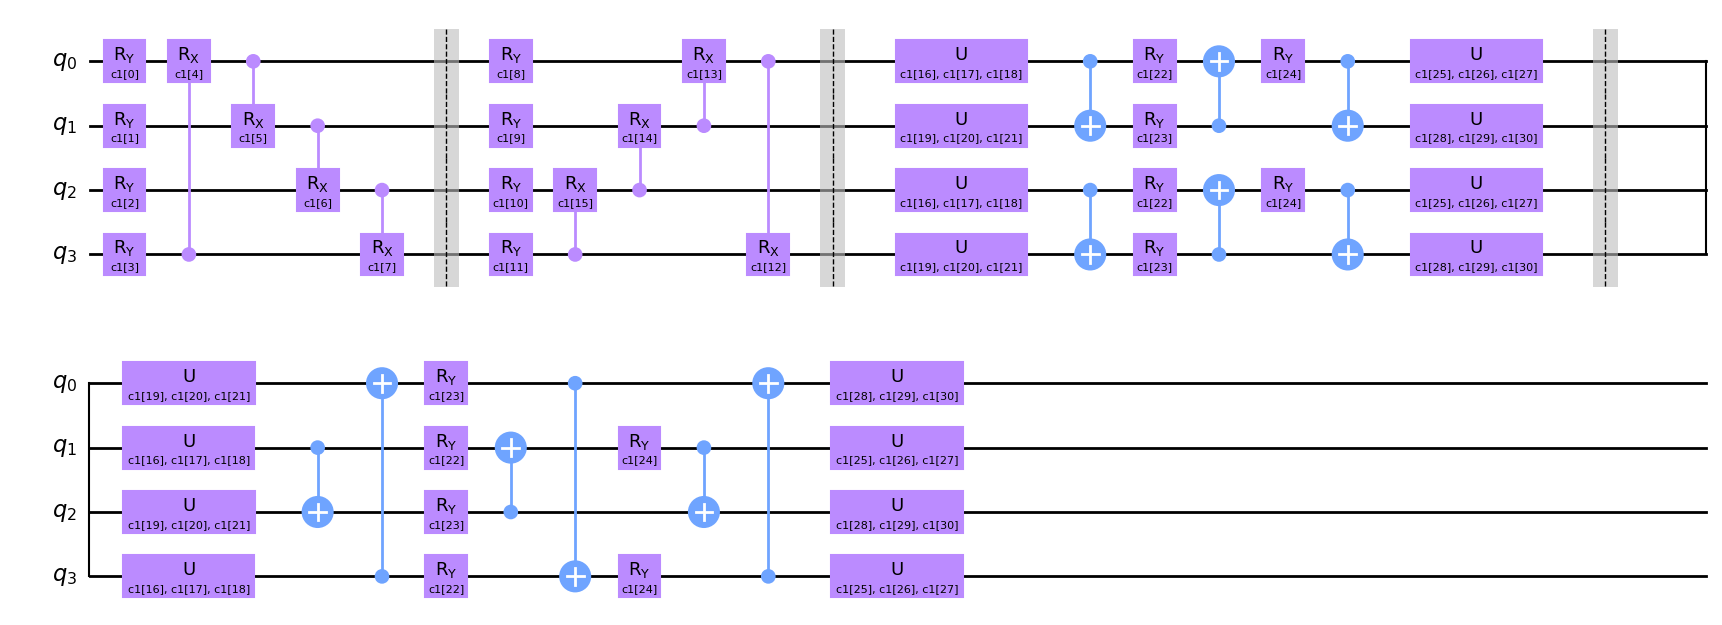

In [15]:
def conv_layer(param_prefix, param_length, F2_params, num_layer, qubits):
    num_qubits = len(qubits)
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    params = ParameterVector(param_prefix, length=param_length)
    local_qubits = list(range(num_qubits))

    start_index = 0
    end_index = num_qubits * 2

    for l in range(num_layer):
        if num_qubits == 8:
            step = num_qubits // 2
            for i in range(0, num_qubits, step):
                sub_params = params[start_index:end_index]
                qc.compose(F1(sub_params, step), local_qubits[i:i + step], inplace=True)
        else:
            end_index += num_qubits * 2
            sub_params = params[start_index:end_index]
            qc.compose(F1(sub_params, num_qubits), local_qubits, inplace=True)
        qc.barrier()
        start_index = end_index
        end_index += F2_params

        for i in range(0, num_qubits, 2):
            sub_params = params[start_index:end_index]
            qc.compose(F2(sub_params), [local_qubits[i], local_qubits[(i + 1) % num_qubits]], inplace=True)
        qc.barrier()
        for i in range(1, num_qubits, 2):
            sub_params = params[start_index:end_index]
            qc.compose(F2(sub_params), [local_qubits[i], local_qubits[(i + 1) % num_qubits]], inplace=True)
        start_index = end_index
        end_index += num_qubits * 2

    inst = qc.to_instruction()
    new_qc = QuantumCircuit(num_qubits)
    new_qc.append(inst, new_qc.qubits)
    return new_qc


qc = conv_layer(
        param_prefix="c1",
        param_length=((4 * 4) + 16) * 1,
        F2_params=16,
        num_layer=1,
        qubits=list(range(4))
    )
qc.decompose().draw('mpl', style="clifford")

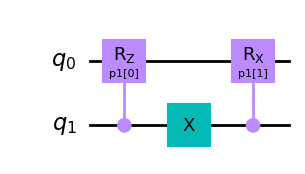

In [16]:
def pooling_layer(param_prefix, param_length, target_qubits, num_qubits):
    qc = QuantumCircuit(num_qubits)
    params = ParameterVector(param_prefix, length=param_length)
    for tq in target_qubits:
        qc.compose(P(params), [qc.qubits[i] for i in tq], inplace=True)
    inst = qc.to_instruction()
    new_qc = QuantumCircuit(num_qubits)
    new_qc.append(inst, new_qc.qubits)
    return new_qc


qc = pooling_layer(
    param_prefix="p1",
    param_length=2,
    target_qubits=[[1, 0]],
    num_qubits=2
)
qc.decompose().draw('mpl', style="clifford")

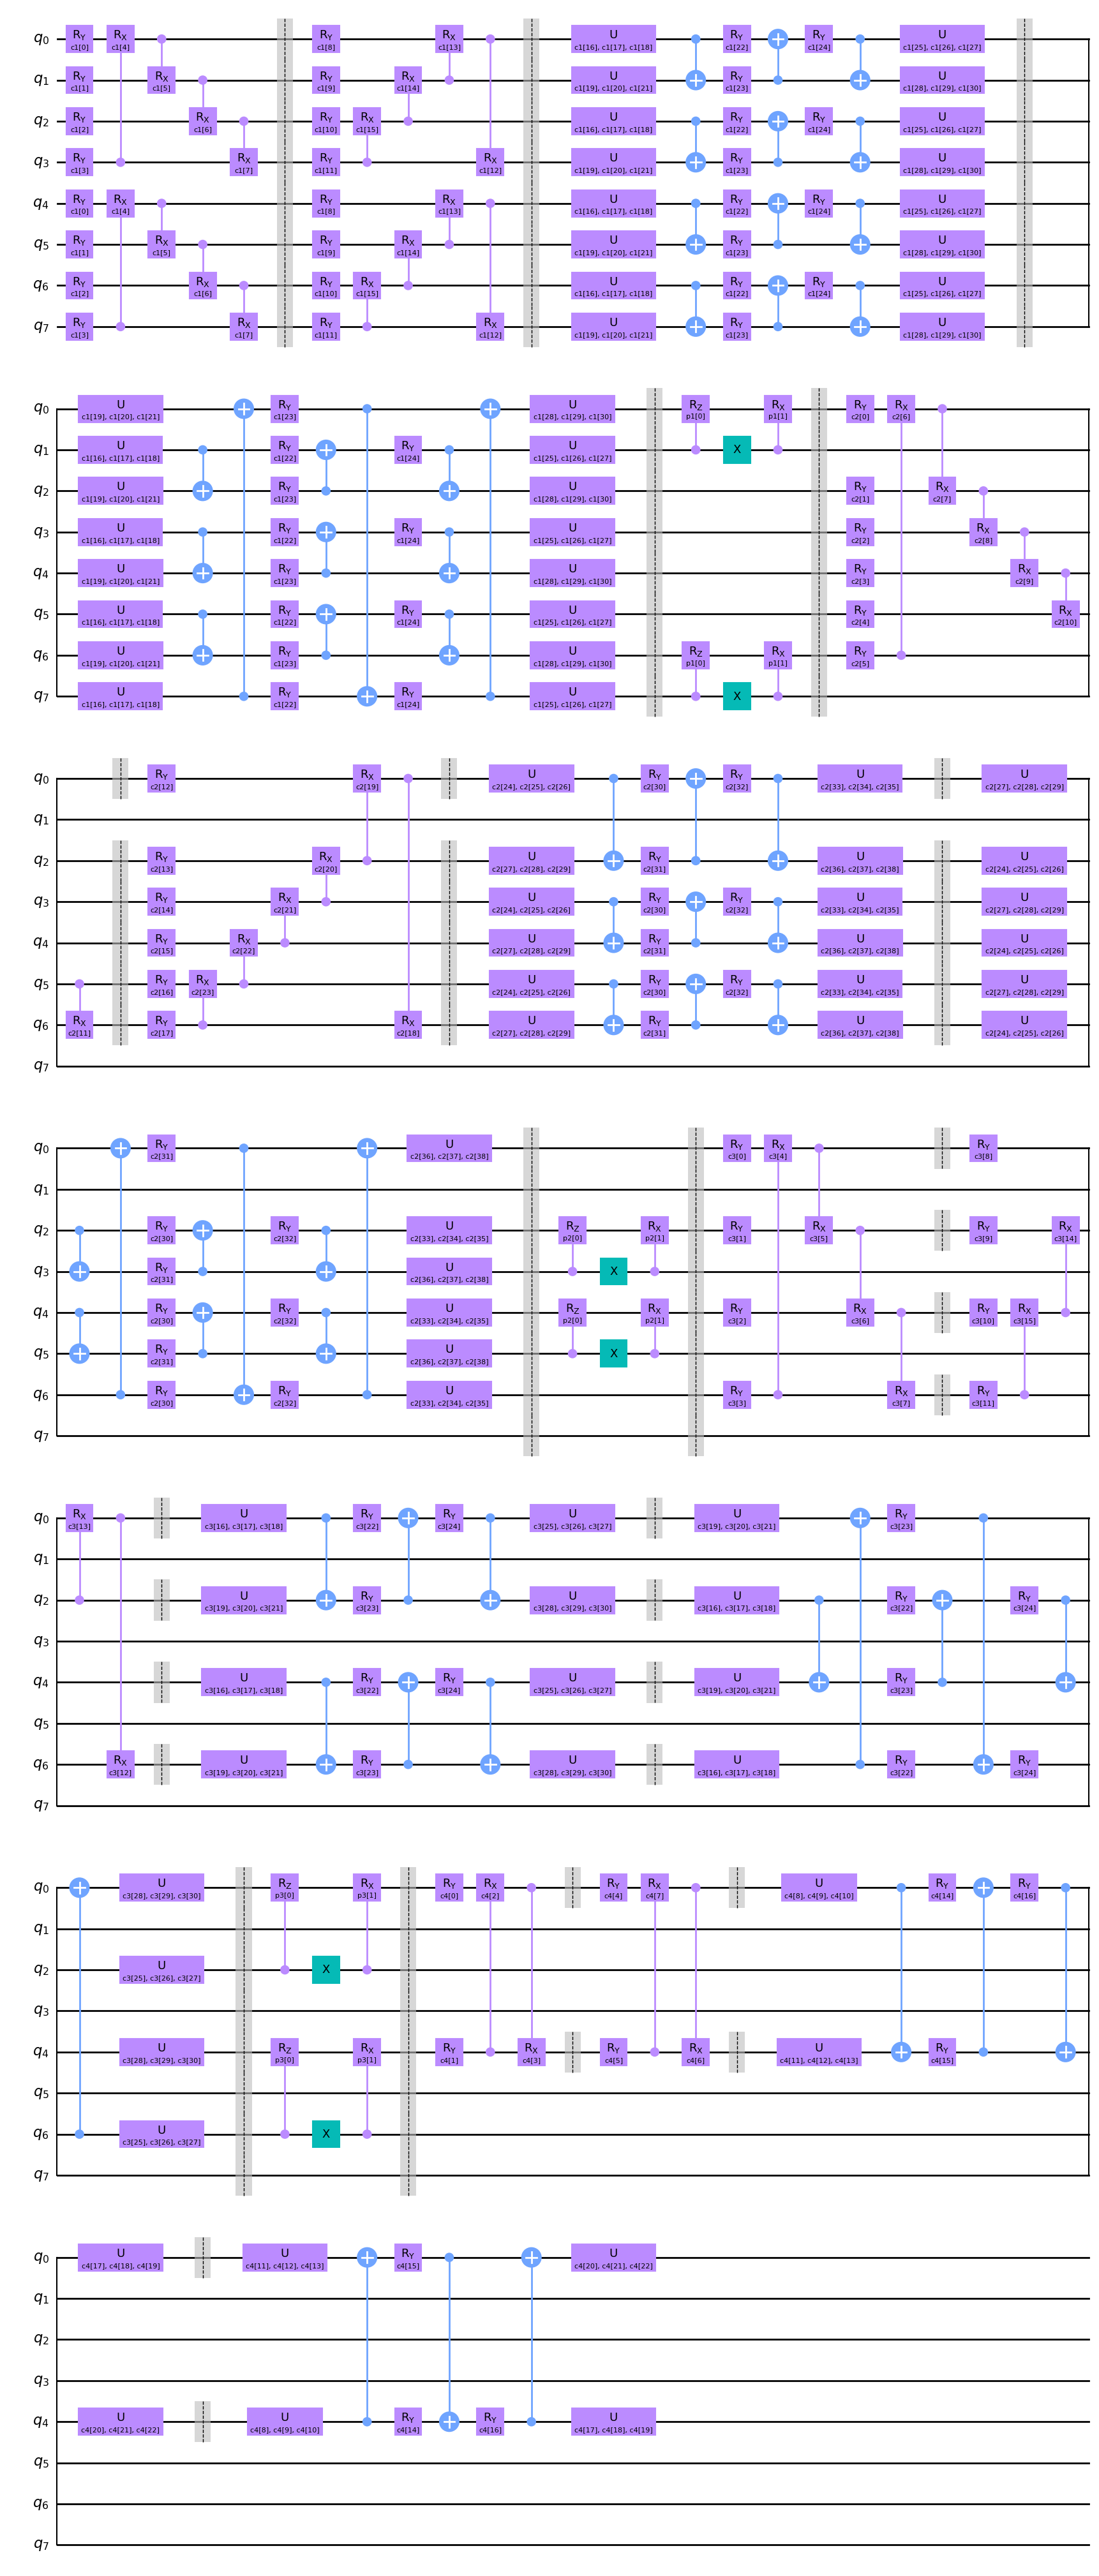

In [18]:
def QCNN(n_qubit=8, measure=False, num_F2_params=16, num_P_params=2, num_layer=1):
    qubits = list(range(n_qubit))

    ansatz = QuantumCircuit(n_qubit, 0 if measure == False else 1,name="Ansatz")

    ansatz.compose(
        conv_layer(
            param_prefix="c1",
            param_length=((n_qubit * 4) + num_F2_params) * num_layer,
            F2_params=num_F2_params,
            num_layer=num_layer,
            qubits=qubits
        ),
        qubits,
        inplace=True
    )
    ansatz.barrier()

    ansatz.compose(
        pooling_layer(
            param_prefix="p1",
            param_length=num_P_params,
            target_qubits=[[7, 6], [1, 0]],
            num_qubits=n_qubit
        ),
        qubits,
        inplace=True
    )
    ansatz.barrier()

    ansatz.compose(
        conv_layer(
            param_prefix="c2",
            param_length=(((n_qubit - 2) * 4) + num_F2_params) * num_layer,
            F2_params=num_F2_params,
            num_layer=num_layer,
            qubits=[0, 2, 3, 4, 5, 6]
        ),
        [0, 2, 3, 4, 5, 6],
        inplace=True
    )
    ansatz.barrier()

    ansatz.compose(
        pooling_layer(
            param_prefix="p2",
            param_length=num_P_params,
            target_qubits=[[3, 2], [5, 4]],
            num_qubits=n_qubit
        ),
        qubits,
        inplace=True
    )
    ansatz.barrier()

    ansatz.compose(
        conv_layer(
            param_prefix="c3",
            param_length=((4 * 4) + num_F2_params) * num_layer,
            F2_params=num_F2_params,
            num_layer=num_layer,
            qubits=[0, 2, 4, 6]
        ),
        [0, 2, 4, 6],
        inplace=True
    )

    ansatz.barrier()

    ansatz.compose(
    pooling_layer(
          param_prefix="p3",
          param_length=num_P_params,
          target_qubits=[[2, 0], [6, 4]],
          num_qubits=n_qubit
      ),
      qubits,
      inplace=True
    )
    ansatz.barrier()

    ansatz.compose(
        conv_layer(
            param_prefix="c4",
            param_length=((2 * 4) + num_F2_params) * num_layer,
            F2_params=num_F2_params,
            num_layer=num_layer,
            qubits=[0, 4]
        ),
        [0, 4],
        inplace=True
    )

    if measure == True:
      ansatz.measure(0, 0)
    return ansatz

ansatz = QCNN(n_qubits, measure=False)
ansatz.decompose().draw('mpl', style="clifford")

In [19]:
ansatz.num_parameters

130

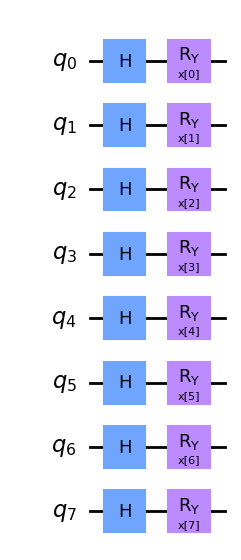

In [ ]:
feature_map = QuantumCircuit(n_qubits)
feature_params = ParameterVector('x', n_qubits)
i=0
for i in range(n_qubits):
    feature_map.h(i)
    feature_map.ry(feature_params[i], i)


feature_map.draw('mpl', style="clifford")

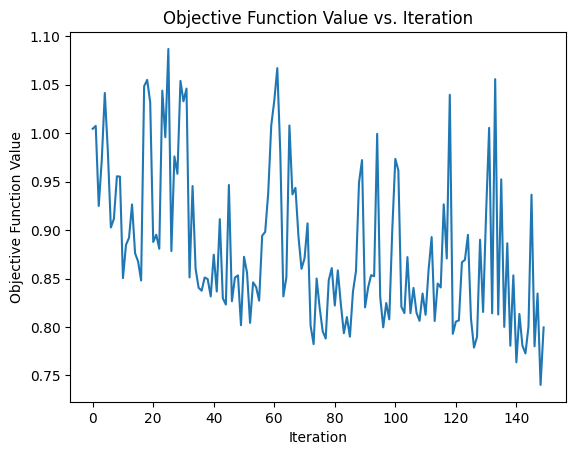

In [ ]:
sampler = Sampler(options=options)
objective_func_vals = []

initial_point = [0.5] * ansatz.num_parameters

classifier = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=maxiter),
    callback=callback_graph,
    loss='cross_entropy',
    output_shape=output_shape,
    initial_point=initial_point,
)

classifier.fit(X_train, Y_train)

In [ ]:
classifier.score(X_test, Y_test)

0.9843971631205674

### Tensor network:

The quantum realization of the quantum matrix product state (QMPS).

In [20]:
def MPS(num_qubits, measure=False, **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.

    """
    qc = QuantumCircuit(num_qubits, 0 if measure == False else 1)
    qubits = range(num_qubits)

    # Iterate over adjacent qubit pairs
    for i, j in zip(qubits[:-1], qubits[1:]):
        qc.compose(RealAmplitudes(num_qubits=2,
                                  parameter_prefix=f'θ_{i},{j}',
                                  **kwargs), [i, j],
                   inplace=True)
        qc.barrier(
        )

    if measure == True:
        qc.measure(qubits[-1], 0)

    return qc

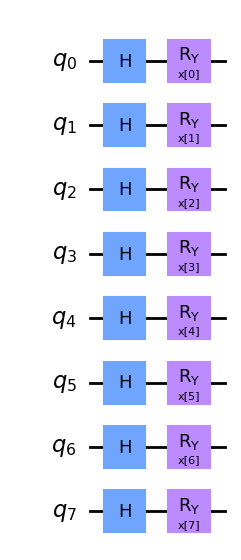

In [21]:
feature_map = QuantumCircuit(n_qubits)
feature_params = ParameterVector('x', n_qubits)
i=0
for i in range(n_qubits):
    feature_map.h(i)
    feature_map.ry(feature_params[i], i)


feature_map.draw('mpl', style="clifford")

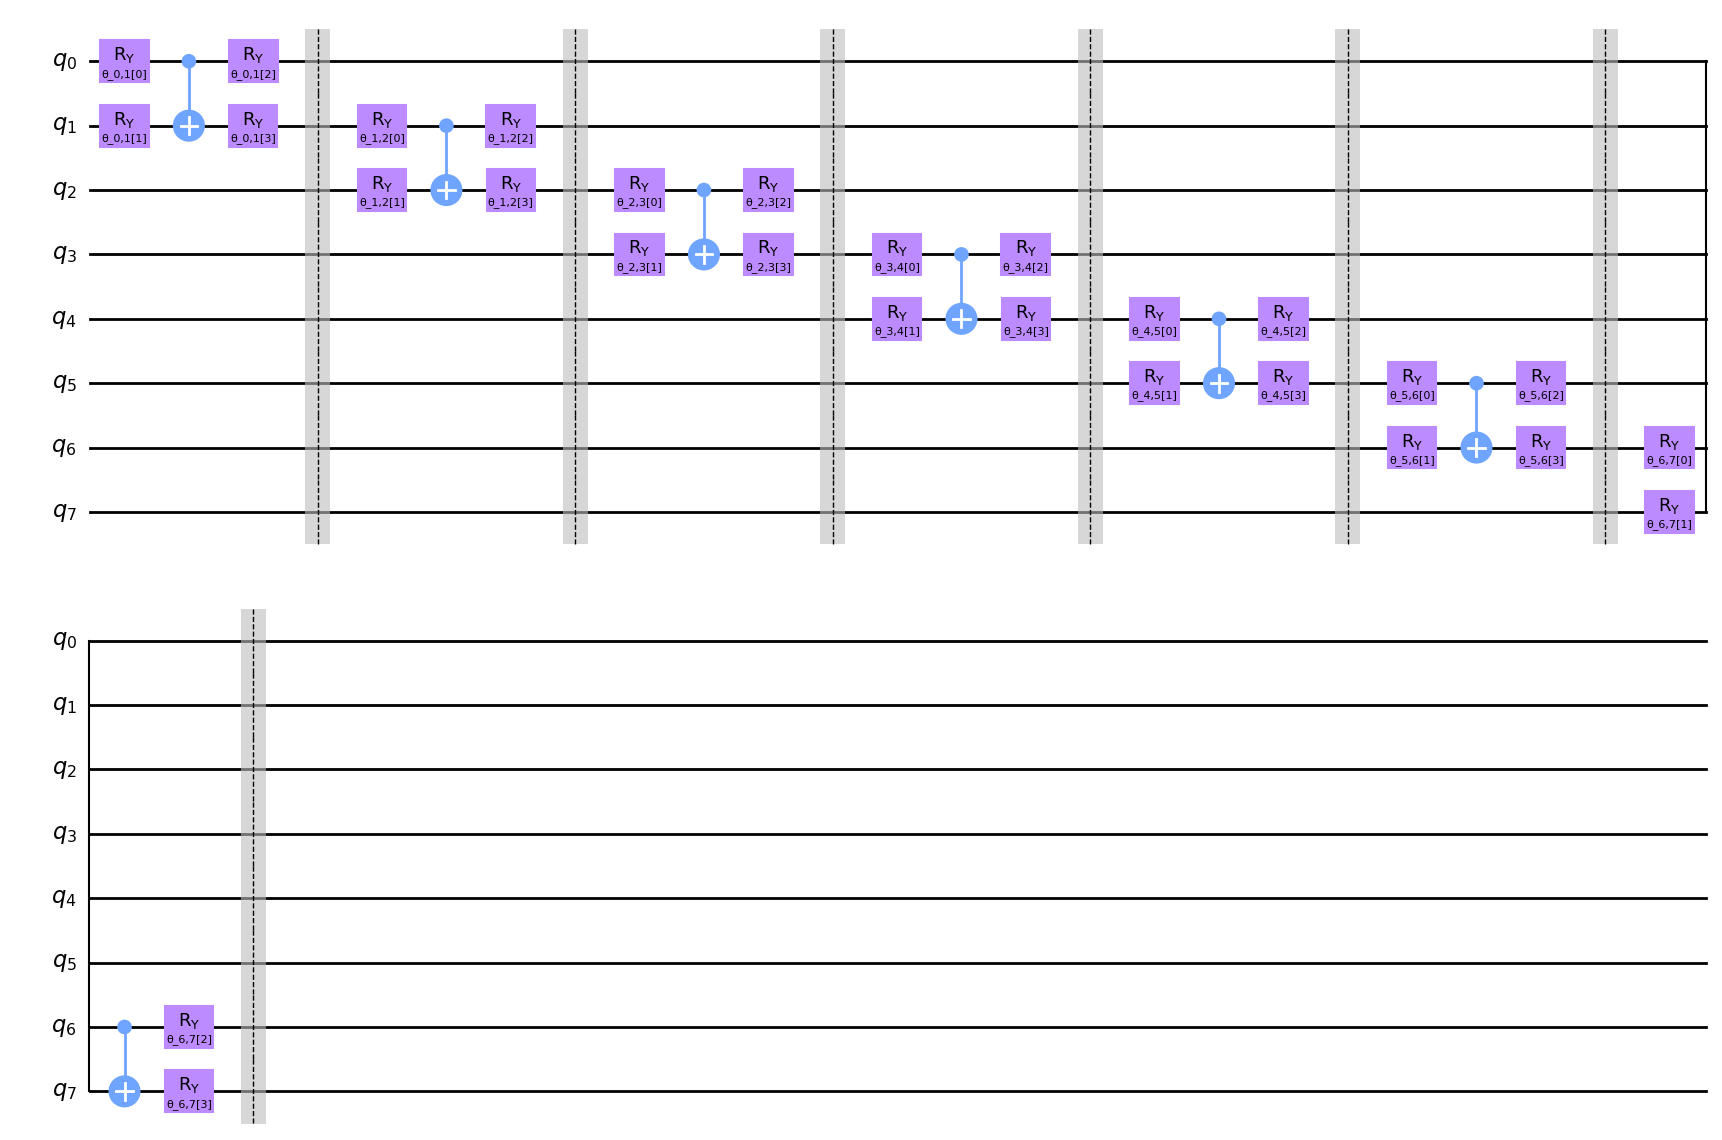

In [29]:
ansatz = MPS(
    n_qubits,
    measure=False,
    reps=1,
    #skip_final_rotation_layer=True
    )
ansatz.decompose().draw('mpl', style="clifford")

In [30]:
ansatz.num_parameters

28

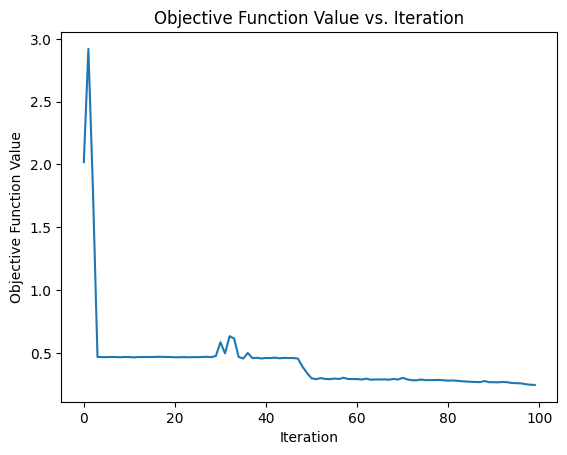

In [31]:
sampler = Sampler(options=options)

objective_func_vals = []
initial_point = [0.5] * ansatz.num_parameters

classifier = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
    loss='cross_entropy',
    output_shape=output_shape,
    initial_point=initial_point,
)

classifier.fit(X_train, Y_train)

In [32]:
classifier.score(X_test, Y_test)

0.9886524822695035

The quantum realization of the quantum tree tensor network (QTTN).

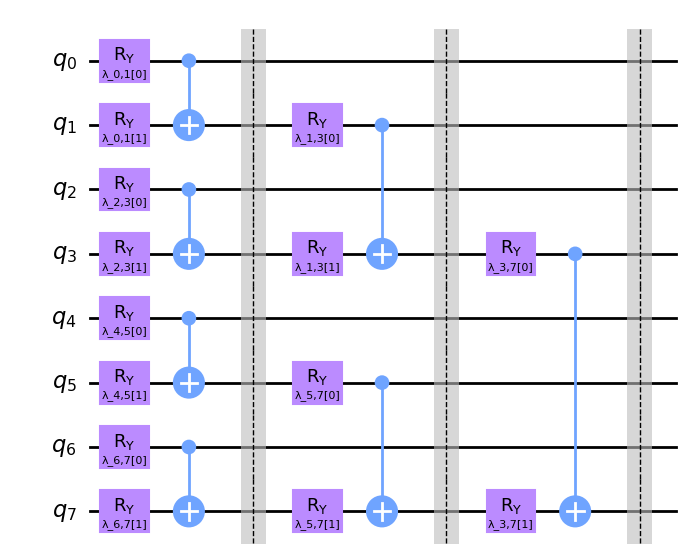

In [36]:
def _generate_tree_tuples(n):
    """
    Generate a list of tuples representing the tree structure
    of consecutive numbers up to n.

    Args:
        n (int): The number up to which the tuples are generated.

    Returns:
        list: A list of tuples representing the tree structure.
    """
    tuples_list = []
    indices = []

    # Generate initial tuples with consecutive numbers up to n
    for i in range(0, n, 2):
        tuples_list.append((i, i + 1))

    indices += [tuples_list]

    # Perform iterations until we reach a single tuple
    while len(tuples_list) > 1:
        new_tuples = []

        # Generate new tuples by combining adjacent larger numbers
        for i in range(0, len(tuples_list), 2):
            new_tuples.append((tuples_list[i][1], tuples_list[i + 1][1]))

        tuples_list = new_tuples
        indices += [tuples_list]

    return indices


def TTN(num_qubits, measure, **kwargs):
    """
    Constructs a Tree Tensor Network (TTN) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed TTN quantum circuit.

    Raises:
        AssertionError: If the number of qubits is not a power of 2
        or zero.
    """
    qc = QuantumCircuit(num_qubits, 0 if measure==False else 1)
    qubits = range(num_qubits)

    # Compute qubit indices
    assert num_qubits & (
            num_qubits -
            1) == 0 and num_qubits != 0, "Number of qubits must be a power of 2"

    indices = _generate_tree_tuples(num_qubits)

    # Iterate over each layer of TTN indices
    for layer_indices in indices:
        for i, j in layer_indices:
            qc.compose(RealAmplitudes(num_qubits=2,
                                      parameter_prefix=f'λ_{i},{j}',
                                      **kwargs), [i, j],
                       inplace=True)
        qc.barrier(
        )  # Add a barrier after each layer for clarity and separation

    if measure == True:
        qc.measure(qubits[-1], 0)

    return qc

ansatz = TTN(
    n_qubits,
    measure=False,
    reps=1,
    skip_final_rotation_layer=True
    )
ansatz.decompose().draw('mpl', style="clifford")

In [37]:
ansatz.num_parameters

14

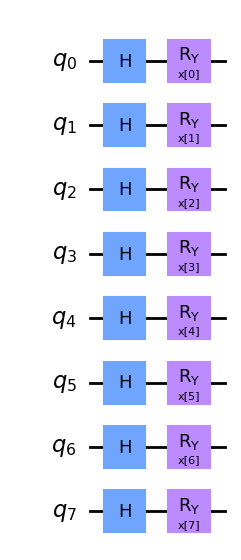

In [38]:
feature_map = QuantumCircuit(n_qubits)
feature_params = ParameterVector('x', n_qubits)
i=0
for i in range(n_qubits):
    feature_map.h(i)
    feature_map.ry(feature_params[i], i)


feature_map.draw('mpl', style="clifford")

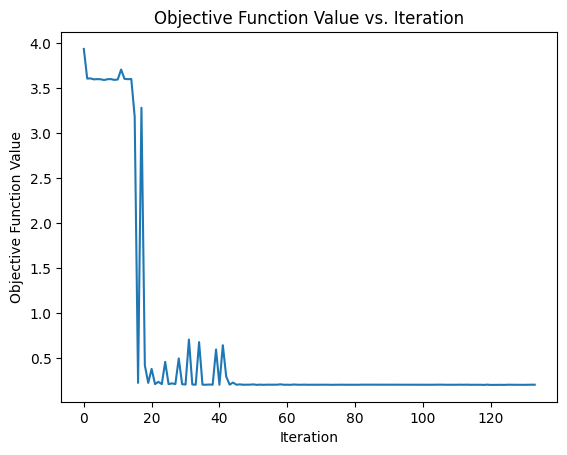

In [39]:
sampler = Sampler(options=options)

objective_func_vals = []
initial_point = [0.5] * ansatz.num_parameters

classifier = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=maxiter),
    callback=callback_graph,
    loss='cross_entropy',
    output_shape=output_shape,
    initial_point=initial_point,
)

classifier.fit(X_train, Y_train)

In [40]:
classifier.score(X_test, Y_test)

0.9900709219858156